In [114]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, rfft

This is a proof of concept of me and Scott's new dispersion algorithm for CHAMPSS. 

In [115]:
Nchan = 16384  # Should probably be 8192 or 16384 to give most accurate kernels
freqs = np.linspace(400.0, 800.0, Nchan)  # in MHz for CHIME band

# A pseudo-impulse response
impulse = np.zeros(1024)
impulse[512] = 1.0

In [116]:
def fft_rotate(arr, bins):
    """
    fft_rotate(arr, bins):
        Return array 'arr' rotated by 'bins' places to the left.  The
            rotation is done in the Fourier domain using the Shift Theorem
            'bins' can be fractional.  The resulting vector will have
            the same length as the original.
    """
    arr = np.asarray(arr)
    freqs = np.arange(arr.size / 2 + 1, dtype=float)
    phasor = np.exp(complex(0.0, 2 * np.pi) * freqs * bins / float(arr.size))
    return np.fft.irfft(phasor * np.fft.rfft(arr), arr.size)


def delay_from_DM(DM, freq):
    """Return the delay caused by DM at freq (MHz)"""
    return DM / (0.000241 * freq**2)

def onewrap_deltaDM(Pspin, Flo=400.0, Fhi=800.0):
    """Return the deltaDM where the dispersion smearing is one pulse period in duration"""
    return Pspin * 0.000241 / (1.0 / Flo**2 - 1.0 / Fhi**2)

The pulses are dispersed by calculating the number of bins as a function of the frequency and the ratio of $\frac{P_{spin}}{N_{chan}}$. A new quantity is calculated called $\Delta DM$, which referrs to the DM value at which the pulse is smeared by one full period.

In [63]:
Pspin = 1.0
Nbins = 1024
deltaDM = onewrap_deltaDM(Pspin)
DMs = np.linspace(0, 3 * deltaDM, 100)
sums = np.zeros((len(DMs), Nbins))
i = 0
for DM in DMs:
    sum = np.zeros(Nbins)
    hidelay = delay_from_DM(DM, freqs[-1])
    #sum = disperse(impulse, DM, hidelay, Pspin, Nbins)
    for freq in freqs:
        bins = -(delay_from_DM(DM, freq) - hidelay) / Pspin * Nbins
        sum += fft_rotate(impulse, bins)
    sums[i] = sum
    i += 1

    if i % 10 == 0:
        print(i)


10
20
30
40
50
60
70
80
90
100


Our harmonics are calculated using the sinc function to disperse the power across channels neighboring the true channel, which almost always has a fractional value.

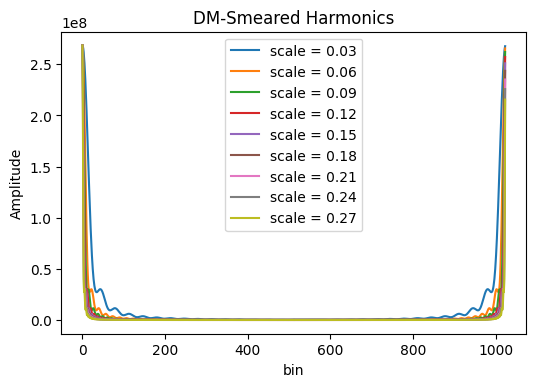

In [136]:
kernels = {}
for i in range(len(DMs)):
    sum_fft = fft(sums[i])
    kernels[DMs[i]/deltaDM] = sum_fft
    if i > 0 and i < 10:
        plt.plot(np.abs(sum_fft)**2, label = f"scale = {np.round(DMs[i]/deltaDM, 2)}")
#plt.imshow(smeared_harm, aspect = 'auto')
plt.title('DM-Smeared Harmonics')
plt.xlabel('bin')
plt.ylabel('Amplitude')
plt.legend()

In [137]:
def sinc(x):
    return np.sin(x)/x


def harmonics(prof_fft, f_true, df, n_harm):
    
    """This function calculates the array of frequency-domain harmonics for a given pulse profile.

    Inputs:
    _______
            prof (ndarray): pulse phase profile
            f_true (float): true rotational frequency in Hz
            df (float)    : frequency bin width in target spectrum

    Returns:
    ________
            harmonics (ndarray) : Fourier-transformed harmonics of the profile convolved with
                                    [cycles] number of Delta functions
    """
    #currently we are calculating the first 10 harmonics in the 2 bins on either side of the true value (2 + 2 = 4)
    harmonics = np.zeros((4*n_harm))
    bins = np.zeros((4*n_harm)).astype(int)
    
    #now evaluate sinc-modified power at each of the first 10 harmonics
    for i in range(1, n_harm + 1):
        f_harm = i*f_true
        bin_true = f_harm/df
        bin_below = np.floor(bin_true)
        bin_above = np.ceil(bin_true)

        #use 2 bins on either side
        current_bins = np.array([bin_below - 1, bin_below, bin_above, bin_above + 1])
        bins[(i - 1)*4:(i - 1)*4+4] = current_bins
        amplitude = prof_fft[i]*sinc(np.pi*(bin_true - current_bins))
        harmonics[(i - 1)*4:(i - 1)*4+4] = np.abs(amplitude)**2

    return bins, harmonics


In [138]:
def gaussian(x, mu, sig):
    return np.exp(-0.5*((x - mu)/sig)**2)/(sig*np.sqrt(2*np.pi))

phi = np.linspace(0, 1, 1024)
pulse = gaussian(phi, 0.5, 0.02)
nfreqbins = 300000
nDMbins = 6000
df = 9.7e-4
n_harm = 30
full_DMs = np.linspace(-3*deltaDM, 3 * deltaDM, nDMbins)
deltaDM = onewrap_deltaDM(1)

We will now look at how dispersion affects the power of a harmonic at a given DM.

In [192]:
def disperse(prof, deltaDM, DM_labels, kernels):
    
    #take the fft of the pulse
    prof_fft = fft(prof)
    i_max = np.argmin(np.abs(2*deltaDM - DM_labels))
    #i is our index referring to the DM_labels in the target power spectrum
    i = - i_max
    dispersed_prof_fft = np.zeros((len(DM_labels), len(prof)))

    keys = np.fromiter(kernels.keys(), dtype=float)
    while i <= i_max:
        #j is the index referring to the DM value in the keys
        '''this can def be optimized by figuring out how many DM bins fit into
        each kernel bin between diff dms and then increasing j by that amount each iteration
        but i will save that for future optimization'''
        j = np.argmin(np.abs(np.abs(DM_labels[i]/deltaDM) - keys))
        dispersed_prof_fft[i] = prof_fft * kernels[keys[j]]
        print(dispersed_prof_fft[i])
        i += 1

    return dispersed_prof_fft

In [193]:
dispersed_prof_fft = disperse(pulse, deltaDM, full_DMs, kernels)
smeared_harm = np.zeros((len(DMs), nfreqbins))
for i in range(len(smeared_harm)):
    bins, harm = harmonics(pulse, 1/Pspin, df, n_harm)
    smeared_harm[i, bins] = harm

/tmp/ipykernel_26385/1354656802.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  dispersed_prof_fft[i] = prof_fft * kernels[keys[j]]


[16760832.00000001  1024690.61179693   313672.26397471 ...
   147181.96162828   313672.26397471  1024690.61179693]
[16760832.00000001  1024690.61179693   313672.26397471 ...
   147181.96162828   313672.26397471  1024690.61179693]
[16760832.00000001  1024690.61179693   313672.26397471 ...
   147181.96162828   313672.26397471  1024690.61179693]
[16760832.00000001  1024690.61179693   313672.26397471 ...
   147181.96162828   313672.26397471  1024690.61179693]
[16760832.00000001  1024690.61179693   313672.26397471 ...
   147181.96162828   313672.26397471  1024690.61179693]
[16760832.00000001  1024690.61179693   313672.26397471 ...
   147181.96162828   313672.26397471  1024690.61179693]
[16760832.00000001  1024690.61179693   313672.26397471 ...
   147181.96162828   313672.26397471  1024690.61179693]
[16760832.00000001  1024690.61179693   313672.26397471 ...
   147181.96162828   313672.26397471  1024690.61179693]
[16760832.00000001  1024690.61179693   313672.26397471 ...
   147181.96162828   

Text(0, 0.5, 'Some Arbitrary Power')

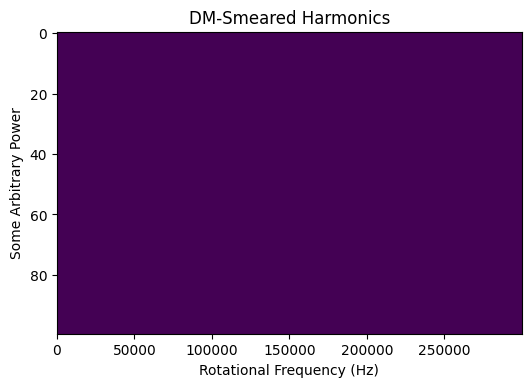

In [172]:
plt.imshow(smeared_harm, aspect = 'auto')
plt.title('DM-Smeared Harmonics')
plt.xlabel('Rotational Frequency (Hz)')
plt.ylabel('Some Arbitrary Power')

Text(0.02, 0.5, 'DM$_{trial}$')

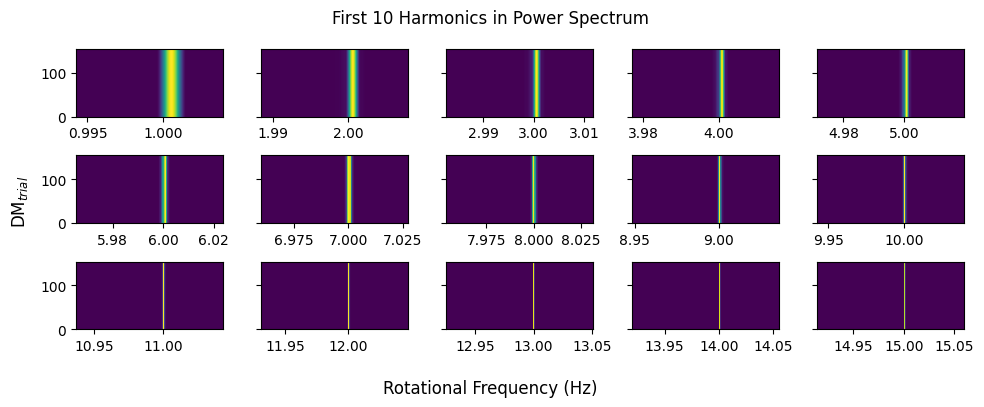

In [173]:
plt.rcParams["figure.dpi"] = 100
fig, ax = plt.subplots(3, 5, figsize=(10, 4), sharey = True, tight_layout = True)
ax = ax.flatten()
for i in range(0, 15):
    ax[i].imshow(smeared_harm[:, (i+1)*1025:(i+1)*1035], 
                 extent = [df*(i+1)*1025, df*(i+1)*1035, 0, max(DMs)],
                  aspect = 'auto')
fig.suptitle('First 10 Harmonics in Power Spectrum')
fig.supxlabel('Rotational Frequency (Hz)')
fig.supylabel(r'DM$_{trial}$')

In [9]:
i = 0
j = 0
harm_power = np.zeros((31, len(DMs)))
while i < len(bins):
    harm_power[j] = np.sum(smeared_harm[:, bins[i:i+4]], axis = 1)
    maxpower = max(harm_power[j])
    harm_power[j] /= maxpower
    i += 4
    j += 1

The plot below shows $P(m_{harm}, \frac{DM}{\Delta DM_{CHIME}})$.

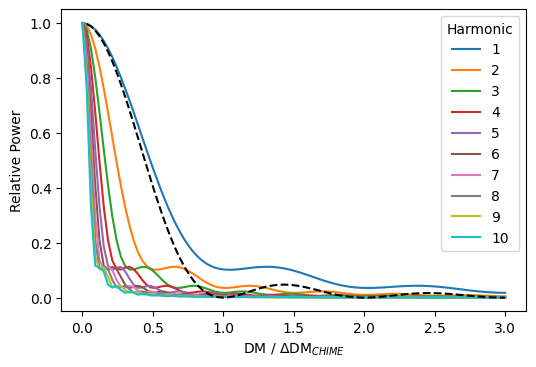

In [40]:
for i in range(10):
    plt.plot(DMs/deltaDM, harm_power[i], label = str(i + 1))
plt.plot(DMs[1:]/deltaDM, sinc(1*np.pi*DMs[1:]/deltaDM)**2, 'k--')
plt.xlabel(r'DM / $\Delta$DM$_{CHIME}$')
plt.ylabel('Relative Power')
plt.legend(title = 'Harmonic')

We're going to store the power scaling factor at each harmonic and DM ratio value in a dictionary of dictionaries for easy referencing. I should probably be doing this in pandas but I'll make that switch once I figure out the later issues I'm encountering.

In [10]:
dict_of_dicts = {}
for harm in range(1, 31):
    scale_dict = {}
    j = 0
    for DM_scale in DMs/deltaDM:
        scale_dict[DM_scale] = harm_power[i, j]
        j += 1
    dict_of_dicts[harm] =  scale_dict

Now we can attempt to reconstruct the harmonics of some arbitrary gaussian pulse profile:

In [11]:
def gaussian(x, mu, sig):
    return np.exp(-0.5*((x - mu)/sig)**2)/(sig*np.sqrt(2*np.pi))

phi = np.linspace(0, 1, 1024)
pulse = gaussian(phi, 0.5, 0.02)

Text(0.5, 1.0, 'Sinc-Approximated Harmonics of our Pulse')

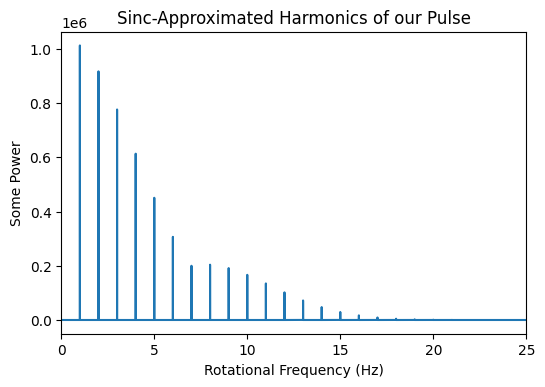

In [12]:
bins, harm = harmonics(pulse, 1/Pspin, df, n_harm)
freq = np.zeros(nfreqbins)
freq[bins] = harm
plt.plot(np.arange(0, nfreqbins, 1)*df, freq)
plt.xlim(0, 25)
plt.xlabel('Rotational Frequency (Hz)')
plt.ylabel('Some Power')
plt.title('Sinc-Approximated Harmonics of our Pulse')

We iterate through the harmonics and disperse each harmonic according to the scale factor for each DM ratio, then inject that dispersed harmonic into a power spectrum.

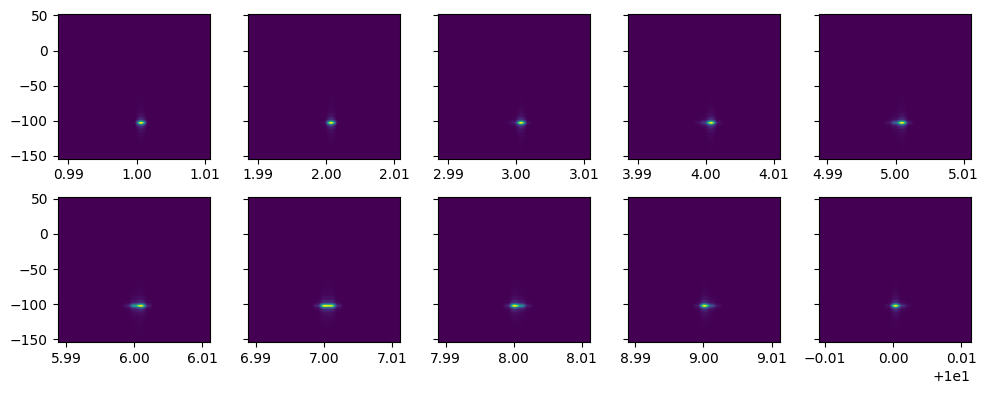

In [61]:
plt.rcParams["figure.dpi"] = 100
fig, ax = plt.subplots(2, 5, figsize=(10, 4), sharey = True, tight_layout = True)
ax = ax.flatten()
ndmbins = 300
full_DMs = np.linspace(-3*deltaDM, 3 * deltaDM, ndmbins)
pspec = np.zeros((ndmbins, nfreqbins))
sectioned_bins = []
for i in range(1, n_harm + 1):
    keys = np.fromiter(dict_of_dicts[i].keys(), dtype=float)
    for j in range(ndmbins):
        DM_scale = full_DMs[j] / deltaDM
        closest_DM_idx = np.argmin(np.abs(keys - np.abs(DM_scale)))
        closest_DM = keys[closest_DM_idx]
        scale = dict_of_dicts[i][closest_DM]
        pspec[j, bins[(i - 1)*4:(i - 1)*4+4]] = harm[(i - 1)*4:(i - 1)*4+4]*scale
        
    if i <= 10:
        start = bins[(i - 1)*4] - 10
        stop = bins[(i - 1)*4+3] + 10
        ax[i - 1].imshow(pspec[:200, start:stop], 
                 extent = [df*start, df*stop, full_DMs[0], full_DMs[200]],
                aspect = 'auto')

Something is wonky here. Why do the bins I use in the first plot like this not work here? I should be injecting at the same bins. Why are some later harmonics so much brighter, even though the sinc plot above shows they shouldn't be? Why are they so wide in frequency-space but narrow in DM?

In [20]:
from scipy.special import erf

In [21]:
def power(dm, t, dnu, sig):
    k = 0.000241
    #a = np.exp((-t**2 - k*dm)/(2*sig**2))/(2*sig**2)
    #b = np.sqrt(t*k*dm/(2*np.pi))
    #c = 
    a = dnu*np.exp(-(t**2 + 2*t*k*dm*dnu**(-2) + k*dm)/(2*sig**2))/(sig*np.sqrt(2*np.pi))
    b = t*k*dm*erf(t*k*dm/(sig**2*dnu**2))/(np.sqrt(2)*sig**3)
    c = -t*k*dm/(np.sqrt(2)*sig**3)

    return a + b + c

Text(0.5, 1.0, 'Analytical Solution That is Definitely Wrong for Total Power Across Band')

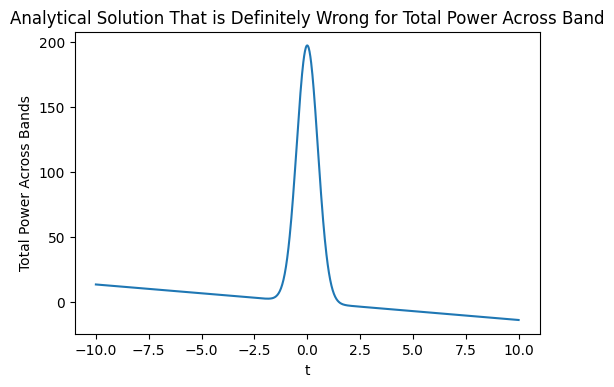

In [43]:
t = np.linspace(-10, 10, 1024)
sig = 0.5
dm = 1000
dnu = 400
dispersed = power(dm, t, dnu, sig)
plt.plot(t, dispersed)
plt.xlabel('t')
plt.ylabel('Total Power Across Bands')
plt.title('Analytical Solution That is Definitely Wrong for Total Power Across Band')